In [47]:
import pandas as pd
import torchaudio
from pathlib import Path
import sys
import numpy as np
import random
import torch
import numpy as np

#set random seeds for reproducibility
SEED = 0
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

repo_root = Path.cwd().parent
sys.path.insert(0, str(repo_root / "src"))

gtcrn_path = repo_root / "src" / "deep_learning" / "gtcrn_model" 
sys.path.insert(0, str(gtcrn_path))

results_dir = repo_root / 'PosterPrep' /'results' / 'spectral'

# model_path = repo_root / 'models' / 'GRU_VAD' /'tiny_vad_best.pth'

from utils.audio_dataset_loader import (
    load_ears_dataset,
    load_noizeus_dataset,
    create_audio_pairs,
    preprocess_audio
)
from utils.generate_and_save_spectrogram import generate_and_save_spectrogram
from utils.compute_and_save_speech_metrics import compute_and_save_speech_metrics
from utils.parse_and_merge_csvs import merge_csvs
from utils.delete_csvs import delete_csvs_in_directory as delete_csvs
from dsp_algorithms.wiener_as import wiener_filter
from dsp_algorithms.wiener_GTCRN import wiener_filter as wiener_gtcrn
from dsp_algorithms.mband_var import mband
from deep_learning.gtcrn_model.gtcrn import GTCRN

In [48]:
def enhance_with_gtcrn(noisy_waveform, model, device, target_sr=16000):
    """
    Enhance noisy speech using GTCRN model.
    
    Args:
        noisy_waveform: Noisy speech tensor [channels, samples] or [samples]
        model: Loaded GTCRN model
        device: Device model is on
        target_sr: Target sampling rate (GTCRN expects 16kHz)
    
    Returns:
        Enhanced speech tensor with same shape as input
    """
    original_shape = noisy_waveform.shape
    
    # Ensure waveform is on correct device and has correct shape
    if noisy_waveform.dim() == 1:
        mix = noisy_waveform.unsqueeze(0)  # Add channel dimension
    else:
        mix = noisy_waveform
    
    # Take first channel if stereo
    if mix.shape[0] > 1:
        mix = mix[0:1, :]
    
    mix = mix.to(device)
    
    # Convert to numpy for STFT (following original implementation)
    mix_np = mix.squeeze(0).cpu().numpy()
    
    # Compute STFT
    input_stft = torch.stft(
        torch.from_numpy(mix_np),
        n_fft=512,
        hop_length=256,
        win_length=512,
        window=torch.hann_window(512).pow(0.5),
        return_complex=False
    ).to(device)
    
    # GTCRN inference
    with torch.no_grad():
        output = model(input_stft[None])[0]
    
    # Reconstruct complex output
    real = output[..., 0]
    imag = output[..., 1]
    complex_output = torch.complex(real, imag)
    
    # Inverse STFT
    enhanced = torch.istft(
        complex_output,
        n_fft=512,
        hop_length=256,
        win_length=512,
        window=torch.hann_window(512).pow(0.5),
        return_complex=False
    )
    
    # Restore original shape
    if len(original_shape) == 1:
        enhanced = enhanced.squeeze()
    else:
        enhanced = enhanced.unsqueeze(0)
    
    return enhanced

In [49]:
# Load test datasets
print("Loading EARS test dataset...")
ears_files = load_ears_dataset(repo_root, mode="test")
print(f"Loaded {len(ears_files)} EARS files for test mode")

print("Loading NOIZEUS test dataset...")
noizeus_files = load_noizeus_dataset(repo_root)
print(f"Loaded {len(noizeus_files)} NOIZEUS files for test mode")

# Create audio pairs
paired_files = create_audio_pairs(noizeus_files, ears_files)
print(f"Created {len(paired_files)} audio pairs for processing")

noise_path, clean_path = paired_files[18]   # Adjust so can choose specific file (noise, emotion), also allow for uploading a file as only the noisy signal 



Loading EARS test dataset...


c:\Users\gabi\Documents\University\Uni2025\Investigation\PROJECT-25P85\src\utils\audio_dataset_loader.py:62: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  info = torchaudio.info(f)
c:\Users\gabi\Documents\University\Uni2025\Investigation\PROJECT-25P85\.venv\Lib\site-packages\torchaudio\_backend\soundfile_backend.py:120: UserWarning: torchaudio._backend.common.AudioMetaData has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://g

Loaded 2395 EARS files for test mode
Loading NOIZEUS test dataset...
Loaded 20 NOIZEUS files for test mode
Created 20 audio pairs
Created 20 audio pairs for processing


In [50]:
noise_path = repo_root / "sound_data" / "raw" / "NOIZEUS_NOISE_DATASET"
babble_noise_path = noise_path / "cafeteria_babble.wav"
street_noise_path = noise_path / "Street Noise_downtown.wav"

clean_sound_path = repo_root / "sound_data" / "raw" / "EARS_DATASET" / "p092"
clean_sound_file = clean_sound_path / "emo_amazement_freeform.wav"

snr_dB = -5

# snr_dB = 0

clean_waveform, noise_waveform, noisy_speech, clean_sr = preprocess_audio(
    clean_speech=clean_sound_file, 
    noisy_audio=babble_noise_path, 
    snr_db=snr_dB
)

# clean_waveform, noise_waveform, noisy_speech, clean_sr = preprocess_audio(
#     clean_speech=clean_path, 
#     noisy_audio=noise_path, 
#     snr_db=snr_dB
# )

Clean speech duration: 16.81s (268908 samples)
Noise duration: 29.05s (464800 samples)
Noise truncated to random frame starting at sample 151468


c:\Users\gabi\Documents\University\Uni2025\Investigation\PROJECT-25P85\.venv\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


In [51]:
# Load GTCRN model
checkpoint_path = gtcrn_path / "checkpoints" / "model_trained_on_dns3.tar"
device = torch.device("cpu")
model = GTCRN().eval().to(device)
ckpt = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(ckpt['model'])

<All keys matched successfully>

In [52]:
if clean_sr != 16000:
    resampler = torchaudio.transforms.Resample(orig_freq=clean_sr, new_freq=16000)
    clean_waveform_16k = resampler(clean_waveform)
    noisy_speech_16k = resampler(noisy_speech)
    processing_sr = 16000
else:
    clean_waveform_16k = clean_waveform
    noisy_speech_16k = noisy_speech
    processing_sr = clean_sr

In [53]:
# Spectral Subtraction 
ss_enh, ss_fs = mband(
    noisy_audio=noisy_speech_16k,
    fs=processing_sr,
    Nband=4,
    Freq_spacing='linear',
    FRMSZ=8,
    OVLP=75,
    AVRGING=1,
    Noisefr=1,
    FLOOR=0.002,
    VAD=1,
)

Using device: cpu


In [54]:
# Wiener Filter 
wf_enh, wf_fs = wiener_filter(
        noisy_audio= noisy_speech_16k,
        fs=clean_sr,
        frame_dur_ms=25,
        mu=0.98,
        a_dd=0.98,
        eta=0.15,
    )

Using device: cpu
Processing tensor input


In [55]:
# Enhance with GTCRN
gtcrn_enhanced = enhance_with_gtcrn(
    noisy_waveform=noisy_speech_16k,
    model=model,
    device=device,
    target_sr=processing_sr
)

In [56]:
# GCTRN with post-Spectral Subtraction 
gtcrn_ss, gtcrn_ss_fs = mband(
    noisy_audio=gtcrn_enhanced,
    fs=processing_sr,
    Nband=4,
    Freq_spacing='linear',
    FRMSZ=8,
    OVLP=75,
    AVRGING=1,
    Noisefr=1,
    FLOOR=0.7,
    VAD=0,
)

Using device: cpu


In [57]:
# GCTRN with post-Wiener Filtering  
gtcrn_wf, gtcrn_wf_fs = wiener_filter(
        noisy_audio=gtcrn_enhanced,
        fs=clean_sr,
        frame_dur_ms=25,
        mu=0.98,
        a_dd=0.98,
        eta=0.15,
    )

Using device: cpu
Processing tensor input


In [58]:
import IPython.display as ipd
import matplotlib.pyplot as plt

print("="*80)
print("SIDE-BY-SIDE COMPARISON")
print("="*80)

# Prepare audio signals for comparison
noisy_compare = noisy_speech.clone().squeeze(0)
clean_compare = clean_waveform.clone().squeeze(0)
noise_compare = noise_waveform.clone().squeeze(0)

# DSP audio 
ss_compare = ss_enh.clone().squeeze(0)
wf_compare = wf_enh.clone().squeeze(0)

# GTCRN audio
gtcrn_compare = gtcrn_enhanced.clone().squeeze(0)
gtcrn_ss_compare = gtcrn_ss.clone().squeeze(0)
gtcrn_wf_compare = gtcrn_wf.clone().squeeze(0)

fs = 16000

print(f"\nAudio lengths before trimming:")
print(f"  noisy:              {len(noisy_compare)}")
print(f"  clean:              {len(clean_compare)}")
print(f"  SS as:              {len(ss_compare)}")
print(f"  WF as:              {len(wf_compare)}")
print(f"  GTCRN as:              {len(gtcrn_compare)}")
print(f"  GTCRN_SS as:              {len(gtcrn_ss_compare)}")
print(f"  GTCRN_WF as:              {len(gtcrn_wf_compare)}")


# Trim to shortest length
min_len = min(
    len(noisy_compare), 
    len(clean_compare),
    len(ss_compare),
    len(wf_compare),
    len(gtcrn_compare),
    len(gtcrn_ss_compare),
    len(gtcrn_wf_compare),
)

noisy_compare = noisy_compare[:min_len]
clean_compare = clean_compare[:min_len]

wf_compare = wf_compare[:min_len]
ss_compare = ss_compare[:min_len]

gtcrn_compare = gtcrn_compare[:min_len]
gtcrn_ss_compare = gtcrn_ss_compare[:min_len]
gtcrn_wf_compare = gtcrn_wf_compare[:min_len]

print(f"\nTrimmed to: {min_len} samples ({min_len/fs:.2f}s)")



SIDE-BY-SIDE COMPARISON

Audio lengths before trimming:
  noisy:              268908
  clean:              268908
  SS as:              268896
  WF as:              268800
  GTCRN as:              268800
  GTCRN_SS as:              268800
  GTCRN_WF as:              268800

Trimmed to: 268800 samples (16.80s)


INDIVIDUAL WAVEFORM PLOTS
WAVEFORM COMPARISON SUBPLOTS


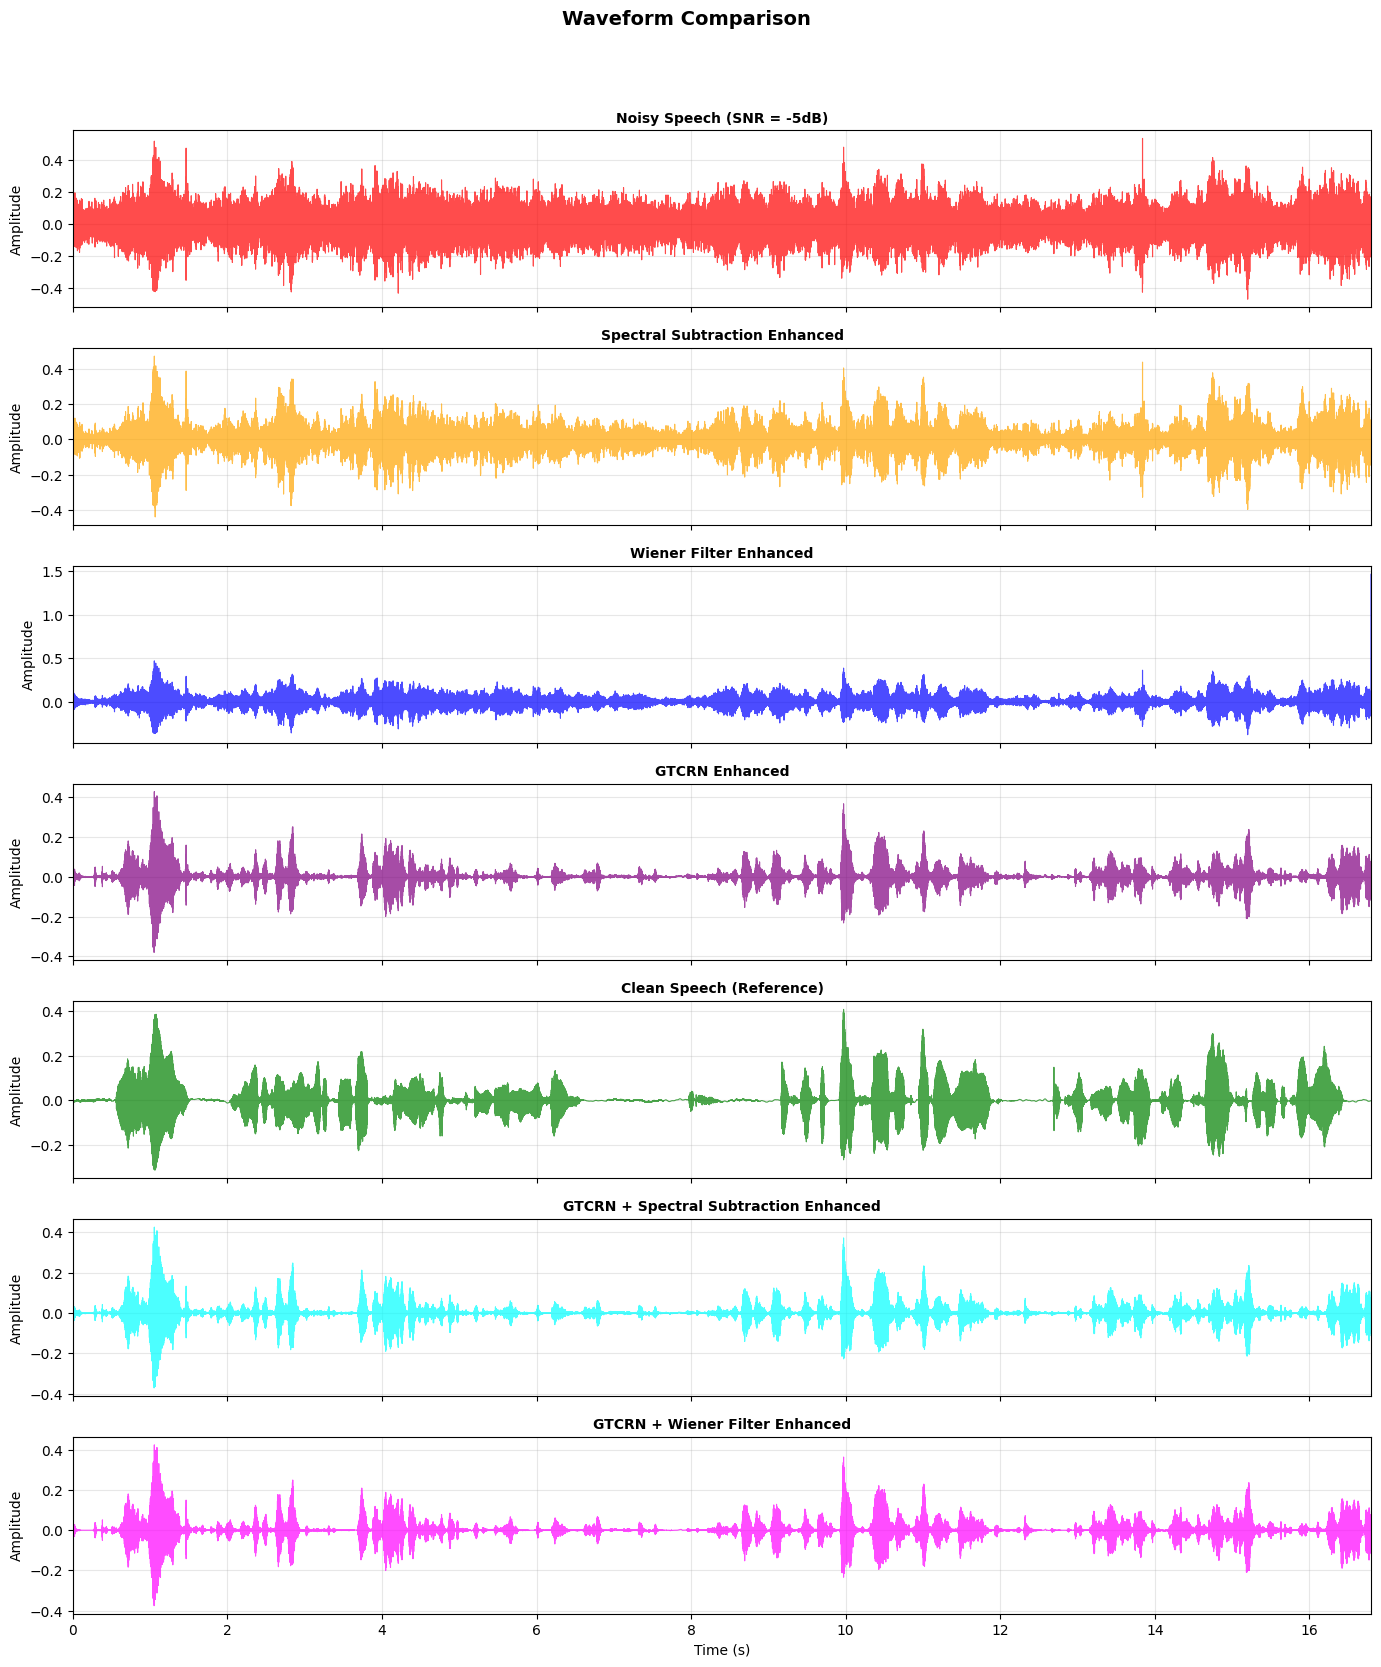

In [59]:
# ============================================================================
# INDIVIDUAL WAVEFORM PLOTS
# ============================================================================
print("="*80)
print("INDIVIDUAL WAVEFORM PLOTS")
print("="*80)

time_axis = np.arange(min_len) / fs

# # Clean Speech (Reference)
# plt.figure(figsize=(14, 3))
# plt.plot(time_axis, clean_compare.numpy(), 'g', alpha=0.7, linewidth=0.8)
# plt.title('Clean Speech (Reference)', fontsize=12, fontweight='bold')
# plt.ylabel('Amplitude')
# plt.xlabel('Time (s)')
# plt.grid(True, alpha=0.3)
# plt.xlim(0, min_len/fs)
# plt.tight_layout()
# plt.show()

# # Noisy Speech
# plt.figure(figsize=(14, 3))
# plt.plot(time_axis, noisy_compare.numpy(), 'r', alpha=0.7, linewidth=0.8)
# plt.title(f'Noisy Speech (SNR = {snr_dB}dB)', fontsize=12, fontweight='bold')
# plt.ylabel('Amplitude')
# plt.xlabel('Time (s)')
# plt.grid(True, alpha=0.3)
# plt.xlim(0, min_len/fs)
# plt.tight_layout()
# plt.show()

# # 2. Spectral Subtraction
# plt.figure(figsize=(14, 3))
# plt.plot(time_axis, ss_compare.numpy(), 'orange', alpha=0.7, linewidth=0.8)
# plt.title('Spectral Subtraction Enhanced', fontsize=12, fontweight='bold')
# plt.ylabel('Amplitude')
# plt.xlabel('Time (s)')
# plt.grid(True, alpha=0.3)
# plt.xlim(0, min_len/fs)
# plt.tight_layout()
# plt.show()

# # 3. Wiener Filter
# plt.figure(figsize=(14, 3))
# plt.plot(time_axis, wf_compare.numpy(), 'blue', alpha=0.7, linewidth=0.8)
# plt.title('Wiener Filter Enhanced', fontsize=12, fontweight='bold')
# plt.ylabel('Amplitude')
# plt.xlabel('Time (s)')
# plt.grid(True, alpha=0.3)
# plt.xlim(0, min_len/fs)
# plt.tight_layout()
# plt.show()

# # 4. GTCRN
# plt.figure(figsize=(14, 3))
# plt.plot(time_axis, gtcrn_compare.numpy(), 'purple', alpha=0.7, linewidth=0.8)
# plt.title('GTCRN Enhanced', fontsize=12, fontweight='bold')
# plt.ylabel('Amplitude')
# plt.xlabel('Time (s)')
# plt.grid(True, alpha=0.3)
# plt.xlim(0, min_len/fs)
# plt.tight_layout()
# plt.show()

# # 5. GTCRN + SS
# plt.figure(figsize=(14, 3))
# plt.plot(time_axis, gtcrn_ss_compare.numpy(), 'cyan', alpha=0.7, linewidth=0.8)
# plt.title('GTCRN + Spectral Subtraction Enhanced', fontsize=12, fontweight='bold')
# plt.ylabel('Amplitude')
# plt.xlabel('Time (s)')
# plt.grid(True, alpha=0.3)
# plt.xlim(0, min_len/fs)
# plt.tight_layout()
# plt.show()

# # 6. GTCRN + Wiener
# plt.figure(figsize=(14, 3))
# plt.plot(time_axis, gtcrn_wf_compare.numpy(), 'magenta', alpha=0.7, linewidth=0.8)
# plt.title('GTCRN + Wiener Filter Enhanced', fontsize=12, fontweight='bold')
# plt.ylabel('Amplitude')
# plt.xlabel('Time (s)')
# plt.grid(True, alpha=0.3)
# plt.xlim(0, min_len/fs)
# plt.tight_layout()
# plt.show()

# plt.tight_layout()
# plt.show()


# ============================================================================
# COMPARISON SUBPLOTS
# ============================================================================
print("="*80)
print("WAVEFORM COMPARISON SUBPLOTS")
print("="*80)

waveforms = [
    (noisy_compare.numpy(), f'Noisy Speech (SNR = {snr_dB}dB)', 'r'),
    (ss_compare.numpy(), 'Spectral Subtraction Enhanced', 'orange'),
    (wf_compare.numpy(), 'Wiener Filter Enhanced', 'blue'),
    (gtcrn_compare.numpy(), 'GTCRN Enhanced', 'purple'),
    (clean_compare.numpy(), 'Clean Speech (Reference)', 'g'),
    (gtcrn_ss_compare.numpy(), 'GTCRN + Spectral Subtraction Enhanced', 'cyan'),
    (gtcrn_wf_compare.numpy(), 'GTCRN + Wiener Filter Enhanced', 'magenta'),
    
]

fig, axs = plt.subplots(len(waveforms), 1, figsize=(14, 2.5 * len(waveforms)), sharex=True)
fig.suptitle('Waveform Comparison', fontsize=14, fontweight='bold')

for i, (waveform, title, color) in enumerate(waveforms):
    axs[i].plot(time_axis, waveform, color=color, alpha=0.7, linewidth=0.8)
    axs[i].set_title(title, fontsize=10, fontweight='bold')
    axs[i].set_ylabel('Amplitude')
    axs[i].grid(True, alpha=0.3)
    axs[i].set_xlim(0, min_len/fs)

axs[-1].set_xlabel('Time (s)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [60]:
# Audio playback comparison
print("\n" + "="*80)
print("AUDIO PLAYBACK COMPARISON")
print("="*80)

print("\nCLEAN SPEECH (Reference):")
display(ipd.Audio(clean_compare.numpy(), rate=fs))   # ON OPEN DAY DONT SHOW THE CLEAN 

print("NOISY SPEECH (5dB SNR):")
display(ipd.Audio(noisy_compare.numpy(), rate=fs))

print("\nSS:")
display(ipd.Audio(ss_compare.numpy(), rate=fs))

print("\nWIENER FILTER:")
display(ipd.Audio(wf_compare.numpy(), rate=fs))

print("\nGTCRN:")
display(ipd.Audio(gtcrn_compare.numpy(), rate=fs))

print("\nGTCRN_SS:")
display(ipd.Audio(gtcrn_ss_compare.numpy(), rate=fs))

print("\nGTCRN WIENER FILTER:")
display(ipd.Audio(gtcrn_wf_compare.numpy(), rate=fs))


AUDIO PLAYBACK COMPARISON

CLEAN SPEECH (Reference):


NOISY SPEECH (5dB SNR):



SS:



WIENER FILTER:



GTCRN:



GTCRN_SS:



GTCRN WIENER FILTER:



GENERATING SPECTROGRAMS FOR ALL SIGNALS

GENERATING COMPARISON SUBPLOT


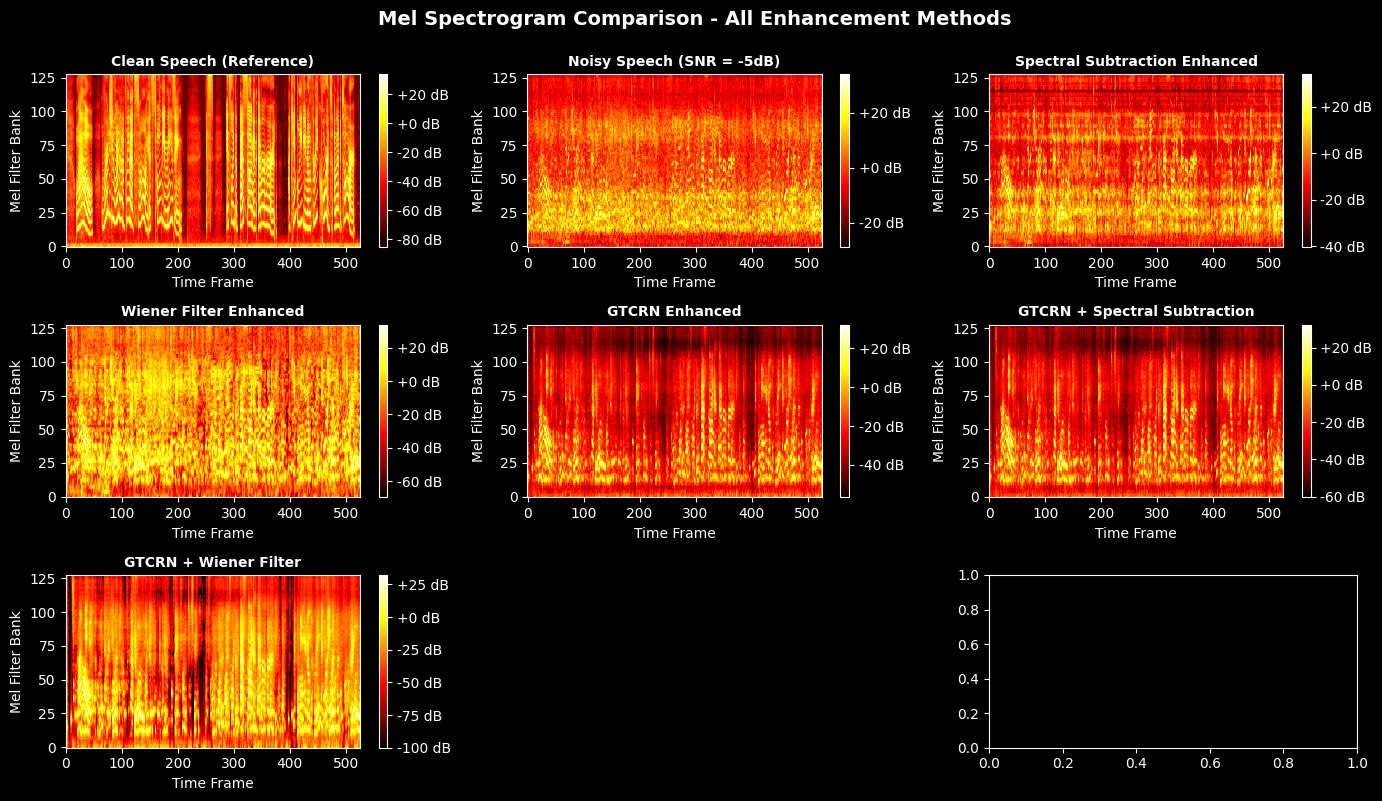


Comparison subplot saved and displayed!


In [61]:
# ============================================================================
# SPECTROGRAM GENERATION FOR ALL SIGNALS
# ============================================================================
print("\n" + "="*80)
print("GENERATING SPECTROGRAMS FOR ALL SIGNALS")
print("="*80)

sample_rate = fs
output_base_path = "spectrograms/comparison"

# Define all signals to process - using 'hot' colormap (black->red->orange->yellow)
signals = {
    "clean": (clean_compare, "Clean Speech (Reference)"),
    "noisy": (noisy_compare, f"Noisy Speech (SNR = {snr_dB}dB)"),
    "ss": (ss_compare, "Spectral Subtraction Enhanced"),
    "wiener": (wf_compare, "Wiener Filter Enhanced"),
    "gtcrn": (gtcrn_compare, "GTCRN Enhanced"),
    "gtcrn_ss": (gtcrn_ss_compare, "GTCRN + Spectral Subtraction"),
    "gtcrn_wiener": (gtcrn_wf_compare, "GTCRN + Wiener Filter"),
}

# # Generate and display spectrograms for each signal individually
# for signal_name, (waveform, title) in signals.items():
#     print(f"\nGenerating spectrogram for: {signal_name}")
    
#     generate_and_save_spectrogram(
#         waveform=waveform,
#         sample_rate=sample_rate,
#         output_image_path=output_base_path,
#         output_file_name=f"{signal_name}_spectrogram",
#         title=f"{title} - Mel Spectrogram",
#         n_mels=128,
#         hop_length=512,
#         n_fft=1024,
#         colormap='hot',
#         include_metadata_in_filename=False
#     )
    
#     # Display the spectrogram
#     display(ipd.Image(filename=f'{output_base_path}/{signal_name}_spectrogram.png'))

# print("\n" + "="*80)
# print("ALL SPECTROGRAMS GENERATED AND DISPLAYED")
# print("="*80)

# ============================================================================
# COMPARISON SUBPLOT - ALL SPECTROGRAMS TOGETHER
# ============================================================================
print("\n" + "="*80)
print("GENERATING COMPARISON SUBPLOT")
print("="*80)

# Set dark background style
plt.style.use('dark_background')

fig, axes = plt.subplots(3, 3, figsize=(14, 8))
fig.patch.set_facecolor('black')
axes = axes.flatten()

# Generate spectrograms directly in subplot
for idx, (signal_name, (waveform, title)) in enumerate(signals.items()):
    # Compute mel spectrogram
    mel_spec = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=1024,
        hop_length=512,
        n_mels=128
    )(waveform)
    
    # Convert to dB scale
    mel_spec_db = torchaudio.transforms.AmplitudeToDB()(mel_spec)
    
    # Plot on subplot with 'hot' colormap (black->red->orange->yellow)
    im = axes[idx].imshow(
        mel_spec_db.numpy(),
        aspect='auto',
        origin='lower',
        cmap='hot',
        interpolation='nearest'
    )
    axes[idx].set_title(title, fontsize=10, fontweight='bold', color='white')
    axes[idx].set_xlabel('Time Frame', color='white')
    axes[idx].set_ylabel('Mel Filter Bank', color='white')
    axes[idx].tick_params(colors='white')
    axes[idx].set_facecolor('black')
    cbar = plt.colorbar(im, ax=axes[idx], format='%+2.0f dB')
    cbar.ax.yaxis.set_tick_params(color='white')
    cbar.outline.set_edgecolor('white')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

# Hide the last (8th) subplot since we only have 7 signals
axes[7].axis('off')

plt.suptitle('Mel Spectrogram Comparison - All Enhancement Methods', 
             fontsize=14, fontweight='bold', y=0.995, color='white')
plt.tight_layout()
plt.savefig(f'{output_base_path}/all_spectrograms_comparison.png', dpi=150, bbox_inches='tight', facecolor='black')
plt.show()

# Reset to default style
plt.style.use('default')

print("\nComparison subplot saved and displayed!")
print("="*80)